# Script for DocX

## Notebook Purpose
DOCX Generation
 
## Tasks
- Data Discover
- Format
- Wrangling
- Analysis
- Jinja2
- Docxtpl

## Notable TODOs:
--

---

# Setup

### Path

In [43]:
import sys
from pathlib import Path

NB_FOLDER = 'notebooks'
NB_PATH = Path.cwd()
B_PATH = NB_PATH.parent

main_spaths = ['scripts', 'data', 'client_credit_union']
main_paths = [(B_PATH / m_spath) for m_spath in main_spaths]
data_spaths = ['external', 'interim', 'processed', 'raw']
data_paths = [(B_PATH / 'data' / data_spath) for data_spath in data_spaths]
data_processed_spaths = ['results', 'training']
data_processed_paths = [(B_PATH / 'data' / 'processed' / datap_spath) for datap_spath in data_processed_spaths]
project_paths = main_paths + data_paths + data_processed_paths

if NB_PATH.stem == NB_FOLDER:
    # Create Project Folders and Set Paths
    for p_path in project_paths:
        p_path.mkdir(exist_ok=True, parents=True)
        p_name = p_path.name
        v_name = f"DATA_{p_name}_PATH" if p_path.parent.name == 'data' else f"{p_name}_PATH"
        globals()[v_name.upper()] = p_path

    # Custom Paths

    # Append SCRIPTS as Python Path
    sys.path.append(client_credit_union_PATH.as_posix())
    sys.path.append(SCRIPTS_PATH.as_posix())

### Installation

In [44]:
!uv add \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==25.2.2
!uv add python-dotenv
!uv add docxtpl
!uv add mammoth docx2md markitdown
!uv add Spire.Doc.Free
!uv remove Spire.Doc.Free
!uv add docx2pdf

Resolved 246 packages in 6ms
Audited 240 packages in 0.09ms
Resolved 246 packages in 0.49ms
Audited 240 packages in 0.09ms
Resolved 246 packages in 0.50ms
Audited 240 packages in 0.07ms
Resolved 246 packages in 0.42ms
Audited 240 packages in 0.07ms
Resolved 248 packages in 556ms                                       
   Building client-credit-union @ file:///home/leobit/Development/interna
   Building client-credit-union @ file:///home/leobit/Development/interna
      Built client-credit-union @ file:///home/leobit/Development/interna
Prepared 1 package in 308ms                                              
Uninstalled 1 package in 0.78ms
Installed 3 packages in 7ms2.0                              
 ~ client-credit-union==0.0.1 (from file:///home/leobit/Development/client-credit-union)
 + plum-dispatch==1.7.4
 + spire-doc-free==12.12.0
Resolved 246 packages in 51ms                                        
   Building client-credit-union @ file:///home/leobit/Development/interna
      Bu

### System Infomation

In [45]:
!bash {SCRIPTS_PATH.as_posix()}/notebook_info.sh

## GLOBAL INFO
Conda Python Version: 3.12.9.final.0
Conda Base Path: /opt/miniconda3
Conda Base Version: 25.1.1

## ENVIRONMENT INFO
Active Environment: None
Environment Python Version: Python 3.11.11
Environment Python Path: /home/leobit/Development/client-credit-union/.venv/bin/python
Environment IPython Version: 9.2.0
Environment IPykernel Version: 6.29.5

## GPU INFO:
CUDA Device Initialized <frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
True

GPU Info: Mon Jun  2 15:31:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.04              Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile U

### Import

In [46]:
## Extensions
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
%load_ext cudf.pandas
%load_ext dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [47]:
import pandas as pd
import warnings
from dotenv import load_dotenv
# import torch
from save_utils import save_obj, load_obj, run_api
from IPython import get_ipython
from IPython.core.magic import register_cell_magic

### Configuration

In [48]:
# Pandas
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Env+
%dotenv {(B_PATH / '.env').as_posix()}
load_dotenv(override=True)

# Torch Version
# print(f"Torch Version: {torch. __version__}")

# Torch Cuda Available
# torch.cuda.is_available()

True

In [49]:
ipython = get_ipython()
@register_cell_magic
def pybash(line, cell):
    ipython.run_cell_magic('bash', '', cell.format(**globals()))

# Reproduce Visualization

In [122]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import matplotlib.colors as mcolors
import matplotlib.cm as cm

## Visualization Utilities

In [123]:
def map_product_type(value):
  val = str(value).upper()

  if "FHA" in val:
    return "FHA"
  elif "VA" in val:
    return "VA"
  elif "NON QM" in val or "NON-QM" in val:
    return "Non-QM"
  elif "CONV" in val or "CONVENTIONAL" in val:
    return "Conventional"
  else:
    return "Other"

def generate_shades(base_hex, n_shades):
  base_rgb = mcolors.to_rgb(base_hex)
  shades = []
  for i in range(n_shades):
    factor = 0.6 + 0.4 * (i / max(1, n_shades - 1))
    shade = tuple(min(1, c * factor) for c in base_rgb)
    shades.append(mcolors.to_hex(shade))
  return shades[::-1]

In [172]:
def plot_volume_by_channel_and_product(df, title_prefix, images_path=None, suffix=""):
  category_matrix = df.groupby(["channel", "product_category"]).agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).reset_index()

  category_matrix["loan_volume_fmt"] = category_matrix["loan_volume"].apply(lambda x: f"${x:,.0f}")
  category_matrix["loan_count_fmt"] = category_matrix["loan_count"].apply(lambda x: f"{x:,}")

  for ch in category_matrix["channel"].unique():
    subset = category_matrix[category_matrix["channel"] == ch][["product_category", "loan_volume_fmt", "loan_count_fmt"]]

    # Table
    fig, ax = plt.subplots(figsize=(8, 1 + 0.4 * len(subset)))
    ax.axis('off')
    table = ax.table(
      cellText=subset.values,
      colLabels=["Product Type", "Loan Volume", "Loan Count"],
      cellLoc='left',
      loc='center',
      colColours=["#c25c4b"] * 3
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    for key, cell in table.get_celld().items():
      if key[0] == 0:
        cell.get_text().set_color("white")
        cell.get_text().set_weight("bold")
        cell.get_text().set_ha("left")

    fig.subplots_adjust(top=0.85)
    fig.text(0.5, 0.91, f"{title_prefix} Loan Volume and Count by Product Type\nChannel: {ch.upper()}",
             ha='center', fontsize=13, weight='bold')
    plt.show()
    if images_path:
      fig.savefig(f"{images_path}final_table_{suffix}_{ch.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.close(fig)

    # Chart
    subset_chart = df[df["channel"] == ch].copy()
    grouped = subset_chart.groupby("product_category").agg(
      loan_volume=("loan_amount", "sum"),
      loan_count=("loanId", "count")
    ).sort_values(by="loan_volume", ascending=False)
    grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
    colors = generate_shades("#d4af37", len(grouped))

    fig, ax = plt.subplots(figsize=(4, 6))
    bars = ax.bar(grouped.index, grouped["loan_volume_m"], color=colors)
    ax.set_title(f"{title_prefix} Loan Volume by Product Type\nChannel: {ch.upper()}",
                 fontsize=13, weight='bold', pad=15)
    ax.set_ylabel("Loan Volume ($M)", fontsize=12)
    ax.set_xlabel("Product Type", fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
    ax.grid(True, axis='y', linestyle='--', linewidth=0.7)
    ax.set_ylim(top=grouped["loan_volume_m"].max() * 1.10)

    for bar, count in zip(bars, grouped["loan_count"]):
      height = bar.get_height()
      ax.annotate(f'{count:,}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 4), textcoords="offset points",
                  ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    if images_path:
      fig.savefig(f"{images_path}final_chart_{suffix}_{ch.lower().replace(' ', '_')}.png")
    plt.close(fig)

  return category_matrix

In [125]:
def plot_volume_by_state(df, title_prefix="Closed", color_base="#d2042d", suffix=None, images_path=None):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mtick

  grouped = df.groupby("state").agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).sort_values(by="loan_volume", ascending=False)
  grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
  colors = generate_shades(color_base, len(grouped))

  fig, ax = plt.subplots(figsize=(8, 6))
  bars = ax.bar(grouped.index, grouped["loan_volume_m"], color=colors)
  ax.set_title(f"{title_prefix} Loan Volume by State", fontsize=13, weight='bold')
  ax.set_ylabel("Loan Amount", fontsize=12)
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
  ax.tick_params(axis='x', labelrotation=45, labelsize=10)
  ax.grid(True, axis='y', linestyle='--', linewidth=0.7)

  for bar, count in zip(bars, grouped["loan_count"]):
    height = bar.get_height()
    ax.annotate(f'{count:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()
  if images_path and suffix:
    fig.savefig(f"{images_path}volume_by_state_{suffix}.png")
  plt.close(fig)

def plot_volume_by_branch_processor(df, title_prefix="Closed", color_base="#a191ff", suffix=None, images_path=None):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mtick

  df = df.copy()
  df["branch_processor"] = df["LoanTeamMember.Name.Branch Processor"].fillna("").str.strip()
  df["branch_processor"] = df["branch_processor"].replace("", "Unassigned")

  grouped = df.groupby("branch_processor").agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).sort_values(by="loan_volume", ascending=False)
  grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
  colors = generate_shades(color_base, len(grouped))

  fig, ax = plt.subplots(figsize=(8, 6))
  bars = ax.bar(grouped.index, grouped["loan_volume_m"], color=colors)
  ax.set_title(f"{title_prefix} Loan Volume by Branch Processor", fontsize=13, weight='bold')
  ax.set_ylabel("Loan Volume ($M)", fontsize=12)
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
  ax.tick_params(axis='x', labelrotation=45, labelsize=10)
  ax.grid(True, axis='y', linestyle='--', linewidth=0.7)

  for bar, count in zip(bars, grouped["loan_count"]):
    height = bar.get_height()
    ax.annotate(f'{count:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

  plt.xticks(rotation=45, ha="right")
  plt.tight_layout()
  plt.show()
  if images_path and suffix:
    fig.savefig(f"{images_path}volume_by_branch_processor_{suffix}.png")
  plt.close(fig)

In [126]:
def plot_projected_closings(
  df,
  date_field="Log.MS.Date.Clear to Close",
  title="Estimated Loan Closings",
  days_ahead=30,
  images_path=None,
  suffix=None
):
  df = df.copy()
  df[date_field] = df[date_field].replace(["//", "...", ""], pd.NA)
  df[date_field] = pd.to_datetime(df[date_field], format="%m/%d/%Y", errors="coerce")

  today = pd.Timestamp.today().normalize()
  horizon = today + pd.Timedelta(days=days_ahead)

  filtered = df[df[date_field].notna()].copy()
  filtered["week"] = filtered[date_field].dt.to_period("W").apply(lambda r: r.start_time)

  grouped = filtered.groupby("week").agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).sort_index()

  if grouped.empty:
    print("No loans with valid 'Clear to Close' dates found.")
    return

  grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
  avg_volume = grouped["loan_volume_m"].mean()
  colors = generate_shades("#00d387", len(grouped))

  fig, ax = plt.subplots(figsize=(5, 6))
  bars = ax.bar(
    grouped.index.astype(str),
    grouped["loan_volume_m"],
    color=colors
  )

  ax.set_title(f"{title} – Next {days_ahead} Days", fontsize=13, weight='bold', pad=10)
  ax.set_ylabel("Loan Volume ($M)", fontsize=12)
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
  ax.tick_params(axis='x', rotation=45, labelsize=10)
  ax.grid(True, axis='y', linestyle='--', linewidth=0.7)

  ax.axhline(avg_volume, color="red", linestyle=':', linewidth=2)
  ax.annotate(f'Avg: ${avg_volume:.1f}M',
              xy=(0.99, avg_volume),
              xycoords=('axes fraction', 'data'),
              xytext=(-10, -10),
              textcoords='offset points',
              ha='right', fontsize=9, color="red")

  for bar, count in zip(bars, grouped["loan_count"]):
    height = bar.get_height()
    ax.annotate(f'{count:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 4), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()
  if images_path and suffix:
    fig.savefig(f"{images_path}projected_closings_{suffix}.png")
  plt.close(fig)

  return grouped.reset_index()

In [127]:
def plot_loan_officer_pareto(df, status_label, images_path=None):
    df = df.copy()
    df["loan_officer"] = df["loan_officer"].fillna("Unassigned").astype(str).str.strip()
    df["loan_officer"] = df["loan_officer"].replace("", "Unassigned")
    df["loan_officer"] = df["loan_officer"].apply(lambda x: " ".join(x.split()))  # Remove múltiplos espaços

    grouped = df.groupby("loan_officer").agg(
        loan_volume=("loan_amount", "sum"),
        loan_count=("loanId", "count")
    ).sort_values(by="loan_volume", ascending=False)

    top20 = grouped.head(20).copy()
    top20["loan_volume_m"] = top20["loan_volume"] / 1_000_000
    top20["cum_pct"] = top20["loan_volume"].cumsum() / top20["loan_volume"].sum() * 100

    fig, ax1 = plt.subplots(figsize=(10, 8))

    x = np.arange(len(top20))

    colors = generate_shades("#e6970c", len(top20))

    bars = ax1.bar(x, top20["loan_volume_m"], color=colors)
    ax1.set_ylabel("Loan Volume ($M)", fontsize=12)
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
    ax1.tick_params(axis='x', labelsize=10)
    ax1.set_xticks(x)
    ax1.set_xticklabels(top20.index, rotation=60, ha="right", fontsize=9)
    ax1.grid(True, axis='y', linestyle='--', linewidth=0.7)

    # ax2 = ax1.twinx()
    # ax2.plot(x, top20["cum_pct"], color="#1f77b4", marker='o', linewidth=2)
    # ax2.set_ylabel("Cumulative % of Volume", fontsize=12)
    # ax2.set_ylim(0, 110)
    # ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    for xi, bar, count in zip(x, bars, top20["loan_count"]):
        height = bar.get_height()
        ax1.annotate(f'{count:,}',
                     xy=(xi, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

    plt.title(f"{status_label} Loan Volume by Loan Officer – Top 20", fontsize=13, weight='bold', pad=10)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(pad=2)
    plt.show()

    if images_path:
        file_label = status_label.lower().replace(" ", "_")
        fig.savefig(f"{images_path}pareto_loan_officer_{file_label}.png")

    plt.close(fig)

## Data

In [190]:
df = pd.read_json(DATA_PROCESSED_PATH / 'loan_field_data.json')

# Flatten records
records = []
for loan in df.to_dict(orient='records'):
  flat_record = {"loanId": loan["loanId"], "folder": loan["folder"]}
  flat_record.update(loan["fields"])
  records.append(flat_record)

df = pd.DataFrame(records)

df["loan_amount"] = df["2"].replace('[\$,]', '', regex=True).astype(float)
df["product_type"] = df["1401"]
df["title_company"] = df["411"]
df["channel"] = df["2626"]
df["state"] = df["14"]
df["loan_officer"] = df["317"]
df["status"] = df["folder"].str.extract(r'(Active|Closed)', expand=False)
df["product_category"] = df["product_type"].apply(map_product_type)
df["branch"] = df["LoanTeamMember.Name.Branch Processor"]

In [193]:
len(df[df["status"] == "Closed"].copy())

126

In [130]:
month_label = "April 2025"

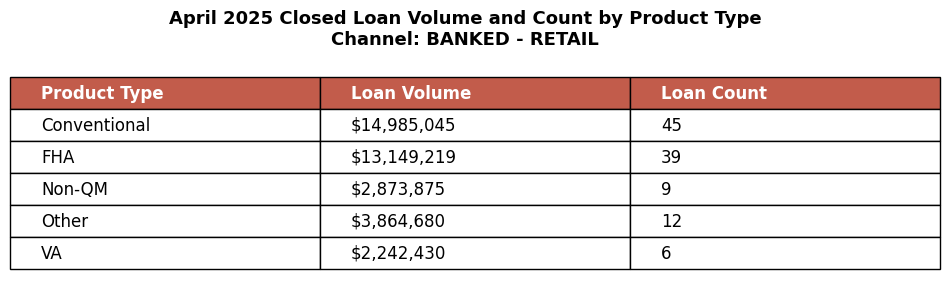

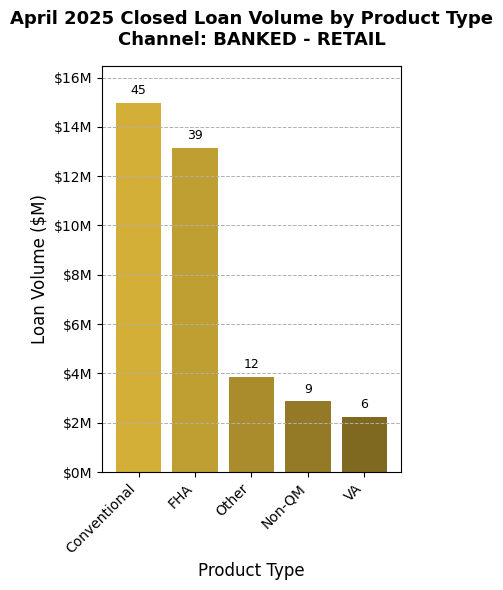

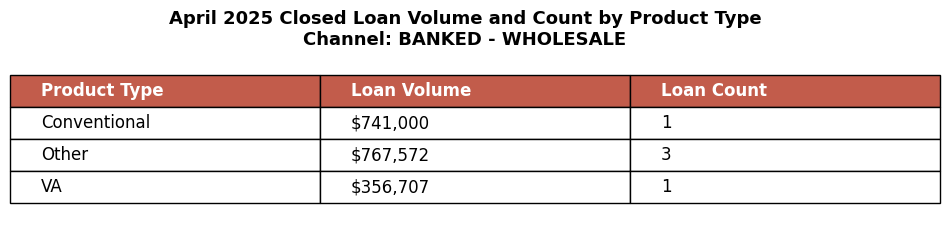

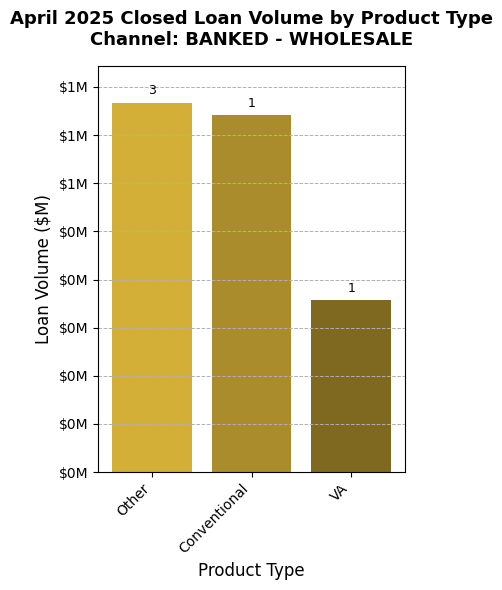

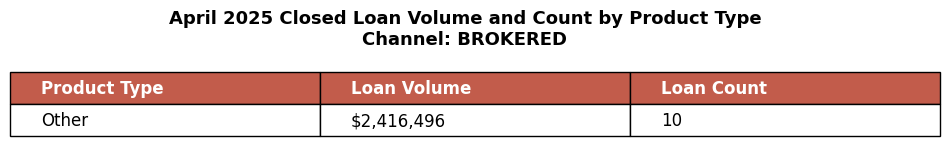

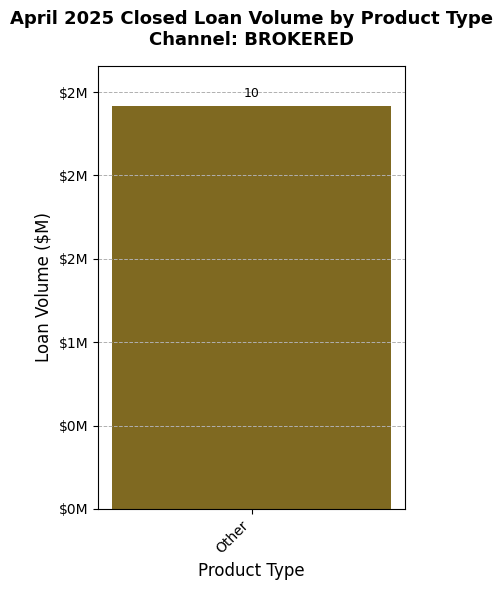

,channel,product_category,loan_volume,loan_count,loan_volume_fmt,loan_count_fmt
0,Banked - Retail,Conventional,14985045.00000,45,"$14,985,045",45
1,Banked - Retail,FHA,13149219.00000,39,"$13,149,219",39
2,Banked - Retail,Non-QM,2873875.00000,9,"$2,873,875",9
3,Banked - Retail,Other,3864680.00000,12,"$3,864,680",12
4,Banked - Retail,VA,2242430.00000,6,"$2,242,430",6
5,Banked - Wholesale,Conventional,741000.00000,1,"$741,000",1
6,Banked - Wholesale,Other,767572.00000,3,"$767,572",3
7,Banked - Wholesale,VA,356707.00000,1,"$356,707",1
8,Brokered,Other,2416496.00000,10,"$2,416,496",10


In [133]:
images_path = (DATA_EXTERNAL_PATH / 'first_report').as_posix() + '/'

closed_df = df[df["status"] == "Closed"].copy()
plot_volume_by_channel_and_product(closed_df, title_prefix=f"{month_label} Closed", suffix="closed", images_path=images_path)

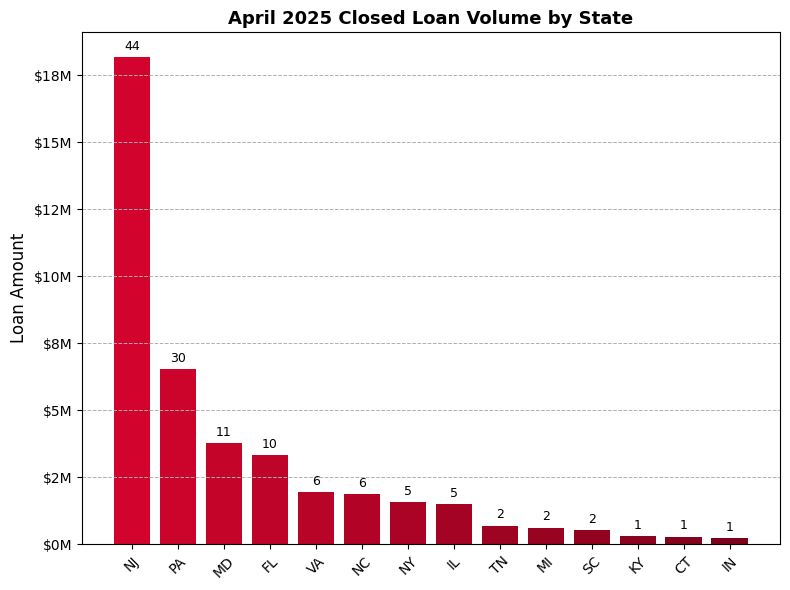

In [134]:
plot_volume_by_state(closed_df, title_prefix=f"{month_label} Closed", suffix="closed", images_path=images_path)

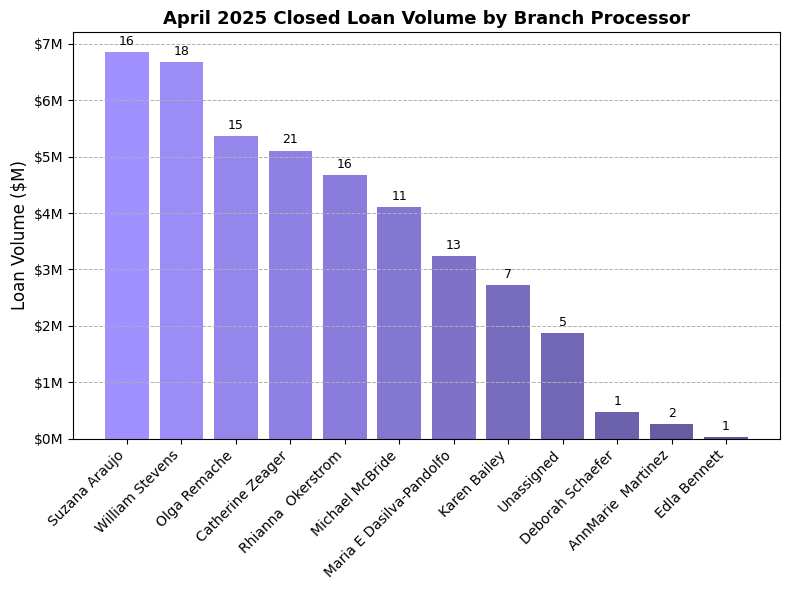

In [135]:
plot_volume_by_branch_processor(closed_df, title_prefix=f"{month_label} Closed", suffix="closed", images_path=images_path)

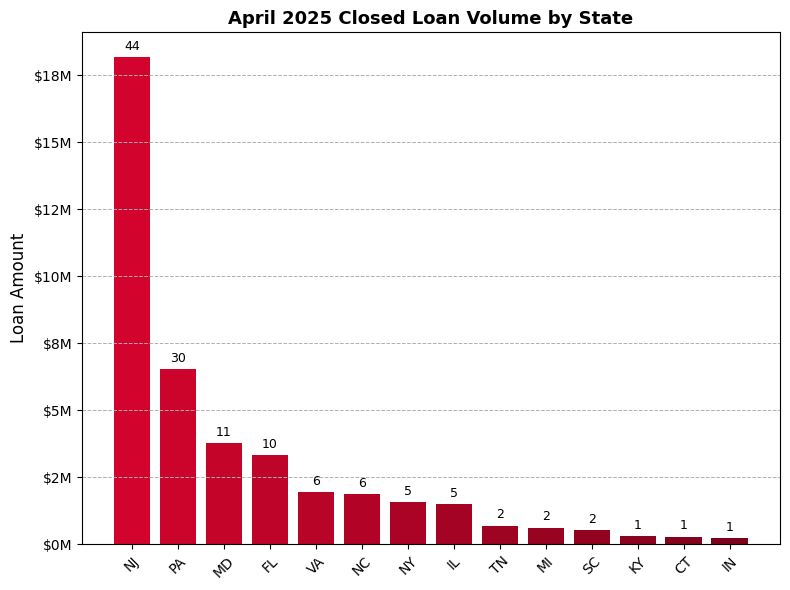

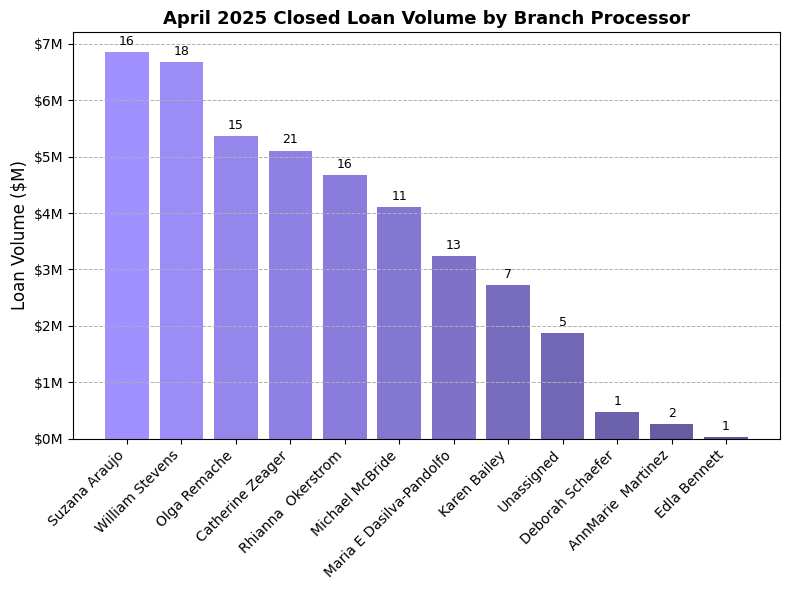

In [60]:
plot_volume_by_state(closed_df, title_prefix=f"{month_label} Closed", suffix="closed")
plot_volume_by_branch_processor(closed_df, title_prefix=f"{month_label} Closed", suffix="closed")

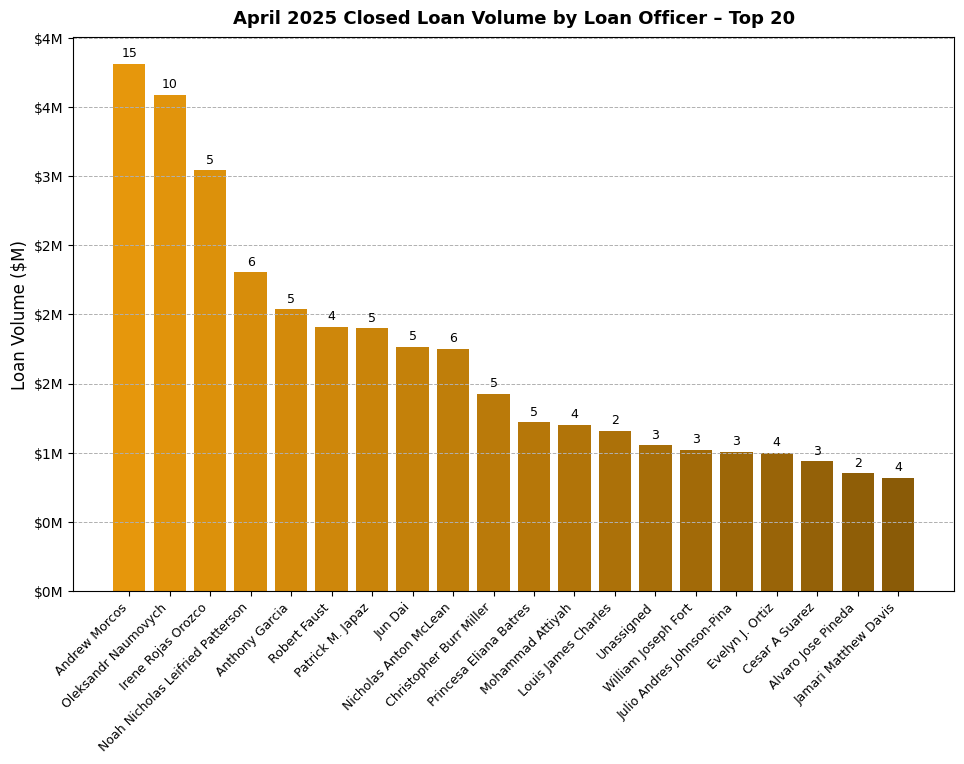

In [136]:
plot_loan_officer_pareto(closed_df, status_label=f"{month_label} Closed", images_path=images_path)

# Active Loan Analysis

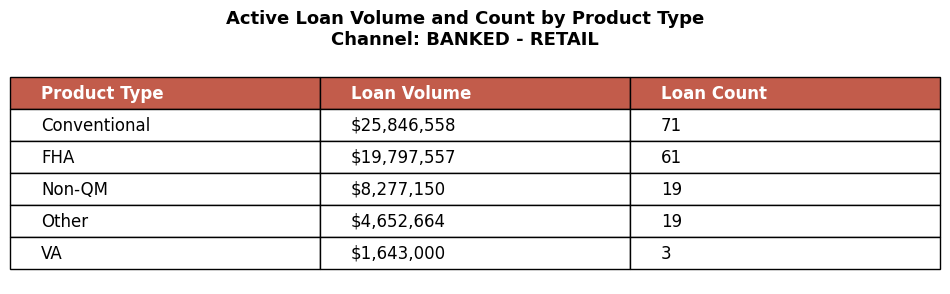

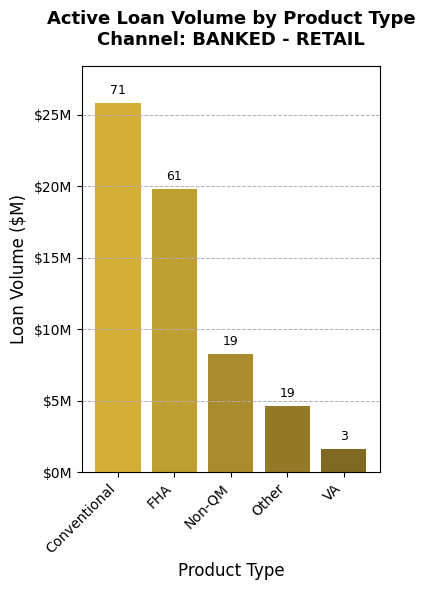

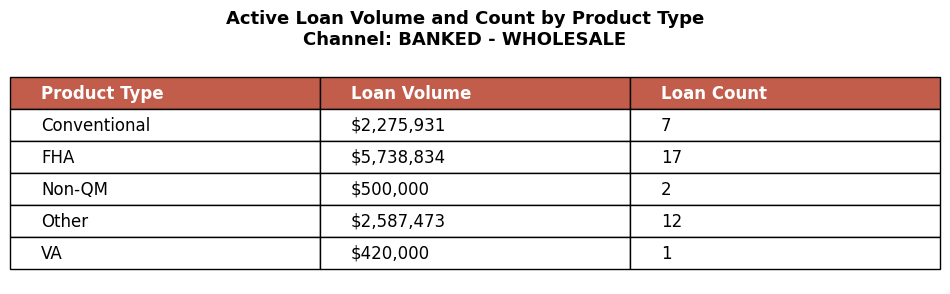

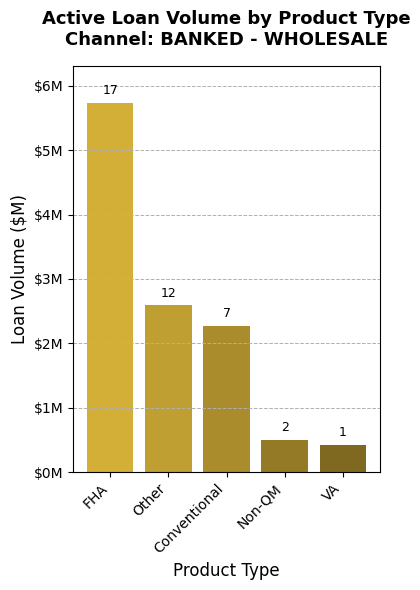

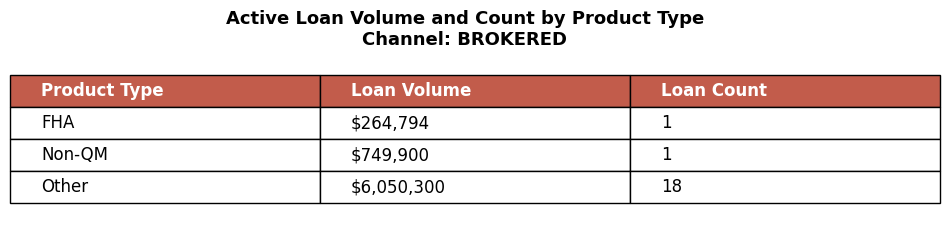

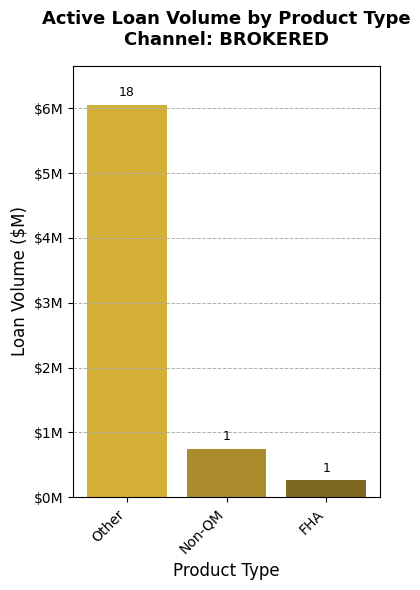

,channel,product_category,loan_volume,loan_count,loan_volume_fmt,loan_count_fmt
0,Banked - Retail,Conventional,25846558.00000,71,"$25,846,558",71
1,Banked - Retail,FHA,19797557.00000,61,"$19,797,557",61
2,Banked - Retail,Non-QM,8277150.00000,19,"$8,277,150",19
3,Banked - Retail,Other,4652664.00000,19,"$4,652,664",19
4,Banked - Retail,VA,1643000.00000,3,"$1,643,000",3
5,Banked - Wholesale,Conventional,2275931.00000,7,"$2,275,931",7
6,Banked - Wholesale,FHA,5738834.00000,17,"$5,738,834",17
7,Banked - Wholesale,Non-QM,500000.00000,2,"$500,000",2
8,Banked - Wholesale,Other,2587473.00000,12,"$2,587,473",12
9,Banked - Wholesale,VA,420000.00000,1,"$420,000",1


In [132]:
active_df = df[df["status"] == "Active"].copy()
plot_volume_by_channel_and_product(active_df, title_prefix="Active", suffix="active", images_path=images_path)

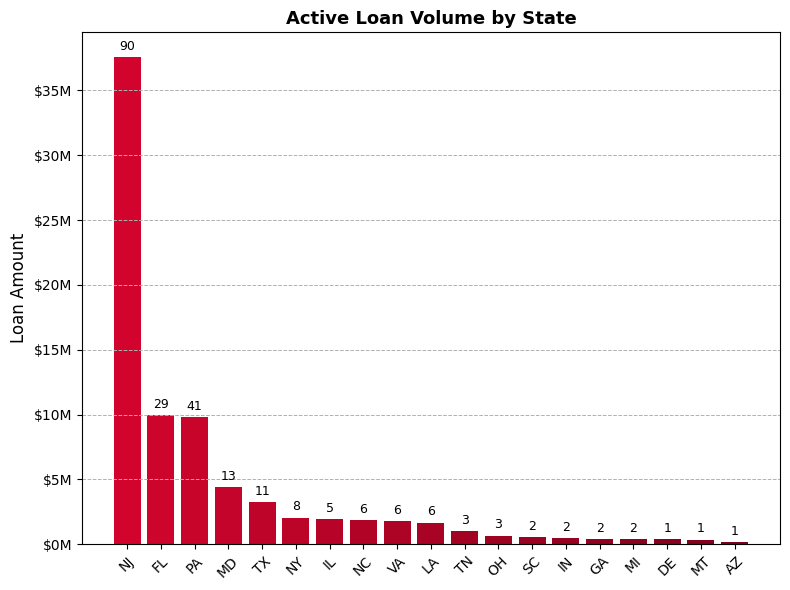

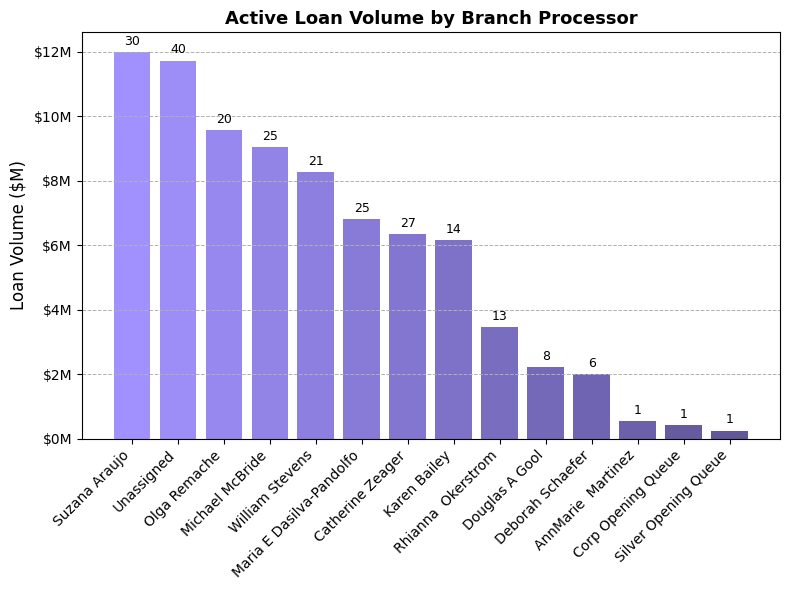

In [45]:
plot_volume_by_state(active_df, title_prefix="Active", suffix="active")
plot_volume_by_branch_processor(active_df, title_prefix="Active", suffix="active")

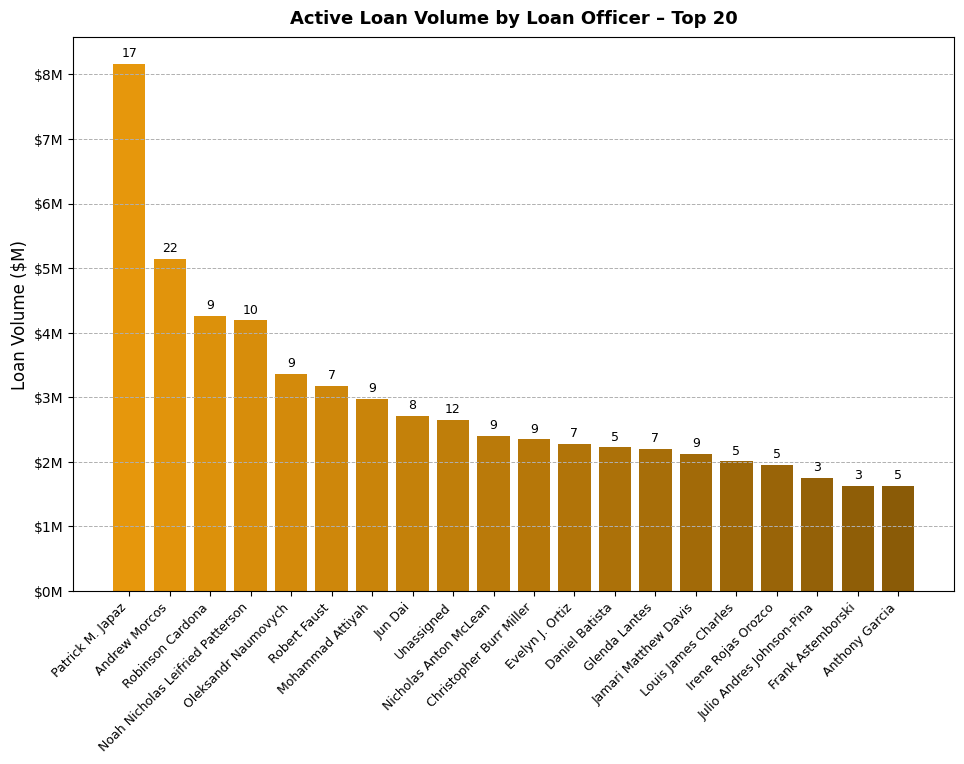

In [46]:
plot_loan_officer_pareto(active_df, status_label="Active")

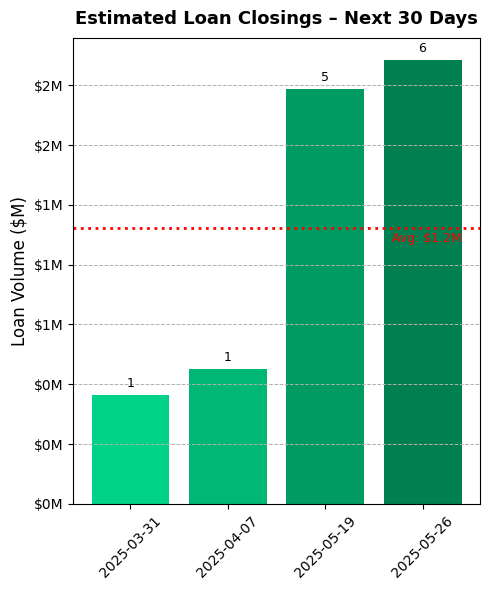

,week,loan_volume,loan_count,loan_volume_m
0,2025-03-31,454400.00000,1,0.45440
1,2025-04-07,562500.00000,1,0.56250
2,2025-05-19,1732658.00000,5,1.73266
3,2025-05-26,1855312.00000,6,1.85531


In [47]:
plot_projected_closings(active_df)

## Markdown

In [22]:
from docxtpl import DocxTemplate
from IPython.display import display, Markdown
import mammoth
from markitdown import MarkItDown

In [ ]:
doc = DocxTemplate(DATA_INTERIM_PATH / 'report_1_closed_v2.docx')
context = { 'cl_qtd' : '10' }
doc.render(context)

<a id="_ftpw9k7c9s7i"></a>Credit Union Report \{\{cl\_report\_num\}\}

<a id="_ocw6p6lmw7lc"></a>Closed Loans Visual Overview

Version \{\{cl\_report\_v\}\}– Data as of \{\{cl\_report\_m\}\} \{\{cl\_report\_d\}\}, \{\{cl\_report\_yr\}\}

# <a id="_ciyawsp2plef"></a>Executive Summary

The Closed \{\{cl\_yr\}\} folder includes __\{\{cl\_qtd\}\} loans__, all of which were __funded in \{\{cl\_fund\_m \}\} \{\{cl\_fund\_yr\}\}__, in line with this month’s reporting criteria\.

__Category__

__Insight__

__Loan Count__

\{\{cl\_qtd\}\} loans funded in \{\{cl\_m\}\} \{\{cl\_yr\}\}

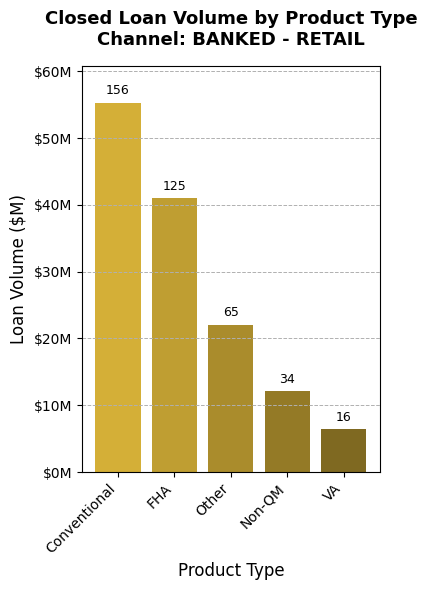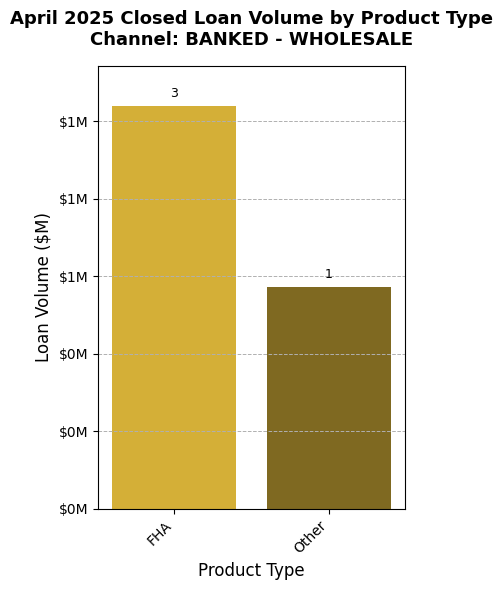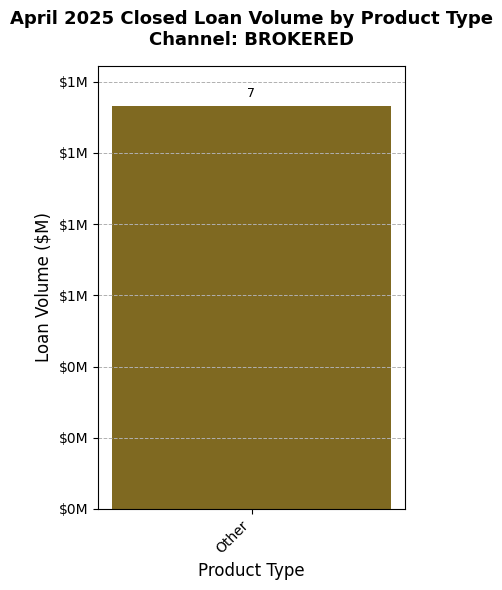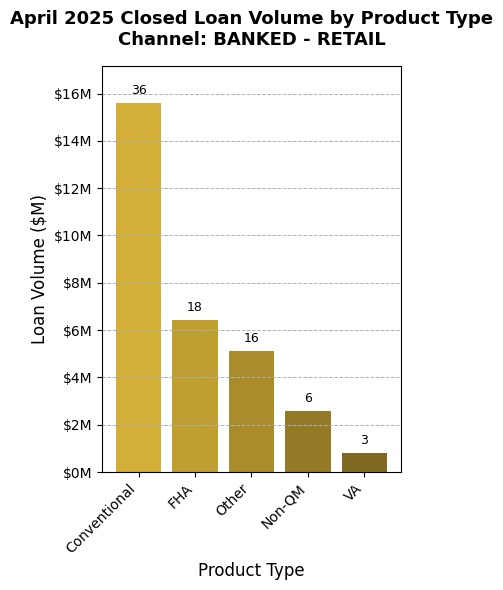

#### <a id="_26uelxso884k"></a>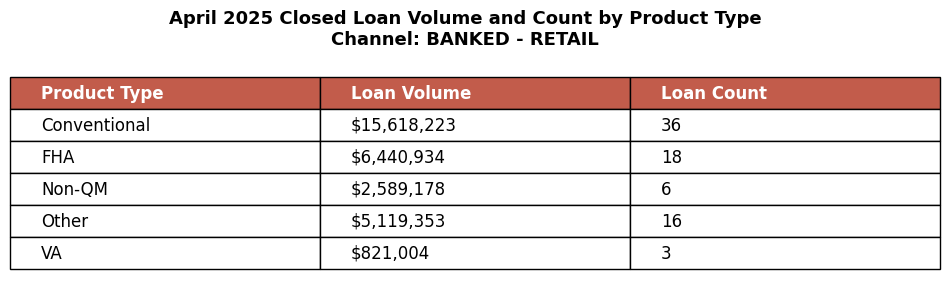

# <a id="_5cu59rd4jm8f"></a>

# <a id="_3vsiiv7jmkux"></a>

# <a id="_4ysb41nz22h1"></a>

# <a id="_lkbcjrtfxbmq"></a>

# <a id="_7h9yucyv0vib"></a>

# <a id="_5mer7y469whi"></a> 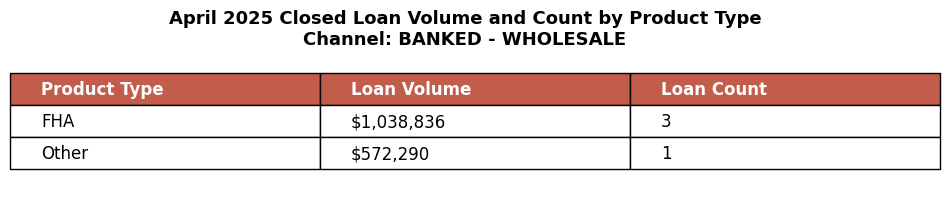

# <a id="_t5gn8zi63enu"></a>

# <a id="_423wg69iyu8j"></a>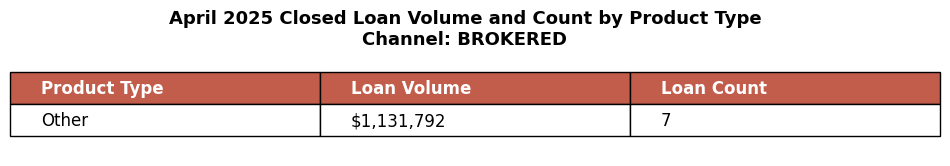

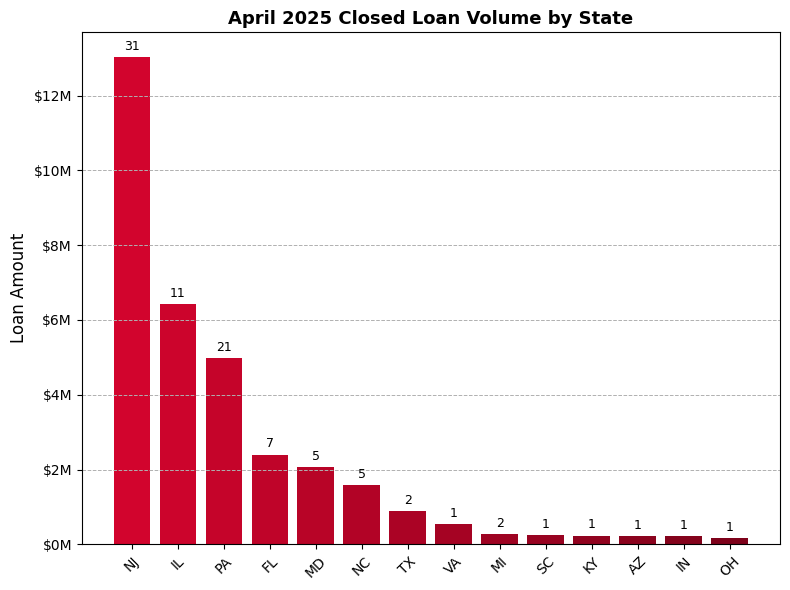

# <a id="_o9cw7qc8s271"></a>

# <a id="_55t6tj17nwzu"></a>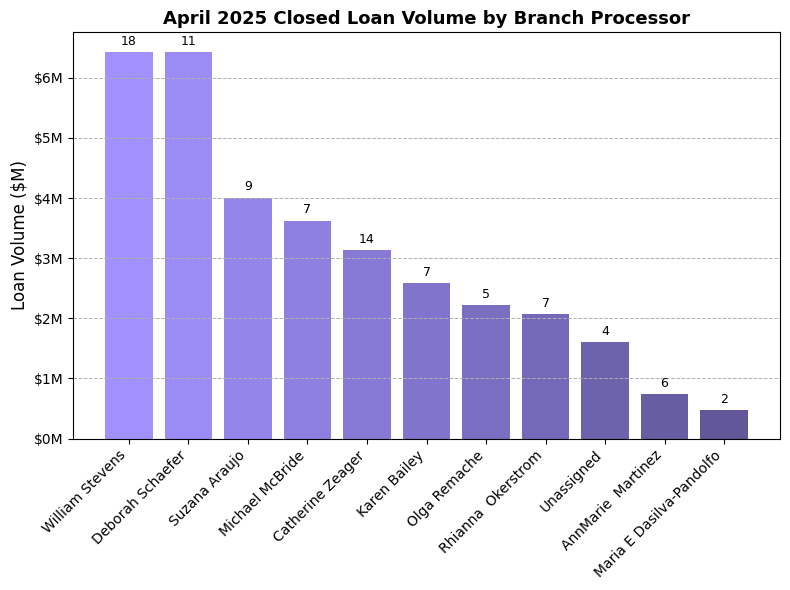

# <a id="_heinow867cf8"></a>

# <a id="_o45f3vgl10c4"></a>

# <a id="_yxgasje81vfk"></a>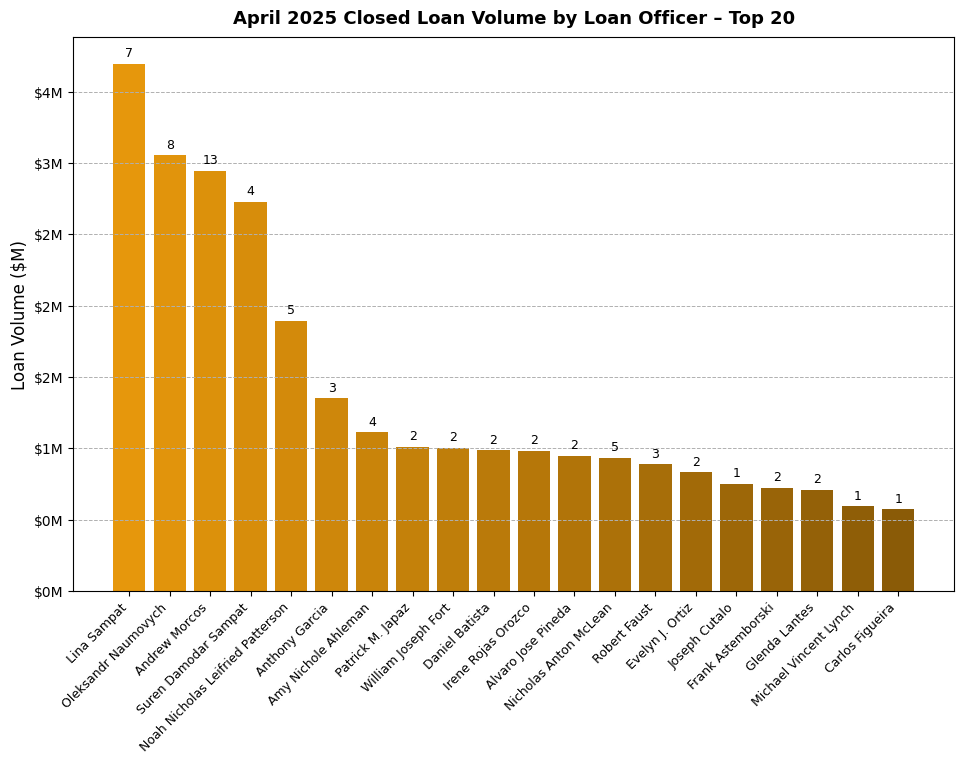

# <a id="_inqanoh5uk3q"></a>

# <a id="_7l3rb9k5fo3c"></a>Appendix A — Product Type Mapping Logic

To standardize reporting, raw product descriptions from Encompass were grouped into broader product categories based on keyword detection\. This mapping ensures consistent reporting across charts and tables\.

## <a id="_xnr4y38o5j2a"></a>Mapping Rules

__Raw Value Contains__

__Mapped Category__

FHA

FHA

VA

VA

NON QM or NON\-QM

Non\-QM

CONV or CONVENTIONAL

Conventional

*\(Other cases\)*

Other

## <a id="_kt509ndmigtq"></a>

## <a id="_xj99nmbhqwje"></a>Example Mappings

- *"FHA 30 YR FIXED"* → __FHA__
- *"VA IRRRL"* → __VA__
- *"Conv 30 Yr Fixed"* → __Conventional__
- *"Non\-QM Bank Statement"* → __Non\-QM__
- *"2nd Lien"* → __Other__
- *“Jumbo” *→ __Other__
- *“Portfolio ARM” *→ __Other__	
- *“USDA” *→ __Other__

__Note:__ Mapping is case\-insensitive and applied using substring matching\.



In [ ]:
markd_doc = mammoth.convert_to_markdown((DATA_INTERIM_PATH / 'report_1_closed_v2.docx').open('rb'))
display(Markdown(markd_doc.value))

In [ ]:
md = MarkItDown()
result = md.convert(DATA_INTERIM_PATH / 'report_1_closed_v2.docx')
display(Markdown(result.text_content))

Credit Union Report {{cl\_report\_num}}

Closed Loans Visual Overview

Version {{cl\_report\_v}}– Data as of {{cl\_report\_m}} {{cl\_report\_d}}, {{cl\_report\_yr}}

# Executive Summary

The Closed {{cl\_yr}} folder includes **{{cl\_qtd}} loans**, all of which were **funded in {{cl\_fund\_m }} {{cl\_fund\_yr}}**, in line with this month’s reporting criteria.

|  |  |
| --- | --- |
| **Category** | **Insight** |
| **Loan Count** | {{cl\_qtd}} loans funded in {{cl\_m}} {{cl\_yr}} |

![](data:image/png;base64...)![](data:image/png;base64...)![](data:image/png;base64...)![](data:image/png;base64...)

#### ![](data:image/png;base64...)

#

#

#

#

#

# ![](data:image/png;base64...)

#

# ![](data:image/png;base64...)

![](data:image/png;base64...)

#

# ![](data:image/png;base64...)

#

#

# ![](data:image/png;base64...)

#

# Appendix A — Product Type Mapping Logic

To standardize reporting, raw product descriptions from Encompass were grouped into broader product categories based on keyword detection. This mapping ensures consistent reporting across charts and tables.

## Mapping Rules

|  |  |
| --- | --- |
| **Raw Value Contains** | **Mapped Category** |
| FHA | FHA |
| VA | VA |
| NON QM or NON-QM | Non-QM |
| CONV or CONVENTIONAL | Conventional |
| *(Other cases)* | Other |

##

## Example Mappings

* *"FHA 30 YR FIXED"* → **FHA**
* *"VA IRRRL"* → **VA**
* *"Conv 30 Yr Fixed"* → **Conventional**
* *"Non-QM Bank Statement"* → **Non-QM**
* *"2nd Lien"* → **Other**
* *“Jumbo”* → **Other**
* *“Portfolio ARM”* → **Other**
* *“USDA”* → **Other**

**Note:** Mapping is case-insensitive and applied using substring matching.

## Docxtpl

In [30]:
from docxtpl import DocxTemplate
import shutil

In [201]:
tpl = DocxTemplate(DATA_INTERIM_PATH / 'report_1_closed_v2.docx')
set_of_variables = tpl.get_undeclared_template_variables()
appendix_sd = tpl.new_subdoc(DATA_INTERIM_PATH / 'report_1-2_v1_appendix.docx')
context = {
    'cl_qtd' : '10',
    'appendix_sd': appendix_sd,
    "show_appendix": "True"
}
tpl.replace_pic(
    "final_chart_closed_brokered",
    (DATA_INTERIM_PATH / "report_1_closed_v2_images" / "img001.png")
)
tpl.render(context, autoescape=True)
tpl.save(DATA_INTERIM_PATH / 'report_1_closed_v2_docxtpl.docx')

In [197]:
set_of_variables

{'appendix_sd',
 'cl_fund_m',
 'cl_fund_yr',
 'cl_qtd',
 'cl_report_d',
 'cl_report_m',
 'cl_report_num',
 'cl_report_v',
 'cl_report_yr',
 'cl_yr',
 'show_appendix'}

In [64]:
img_num = 0
for path in sorted((DATA_INTERIM_PATH / "report_1_closed_v2_images").glob("*")):
	if not path.suffix in [".png", ".jpg", ".jpeg"]:
		path.unlink()
	else:
		img_num += 1
		path.rename(DATA_INTERIM_PATH / "report_1_closed_v2_images" / f"img{img_num:03d}{path.suffix}")

In [159]:
from docx import Document
from docx.parts.image import ImagePart

def get_image_alt_texts(docx_path):
    """
    Extracts alt text from images within a .docx file.

    Args:
        docx_path (str): The path to the .docx file.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              the image's alt text ('title' and/or 'description') and its index.
    """

    document = Document(docx_path)
    image_alt_texts = {}
    image_index = 0

    for paragraph in document.paragraphs:
        for run in paragraph.runs:
            for inline_shape in run._element.findall('.//' + qn('wp:anchor')) + run._element.findall('.//' + qn('wp:inline')):
                docPr = inline_shape.find(qn('wp:docPr'))
                if docPr is not None:
                    alt_text_descr = docPr.get('descr')
                    if alt_text_descr:
                        image_alt_texts[image_index] = alt_text_descr
                    image_index += 1
    return image_alt_texts

In [160]:
docx_file = (DATA_INTERIM_PATH / 'report_1_closed_v2.docx').as_posix()  # Replace with your file path
alt_texts = get_image_alt_texts(docx_file)
if alt_texts:
	for image_index, image_data in alt_texts.items():
		print(f"Image Index: {image_index}")
		print(f"Image Data: {image_data}")
		# print(f"Image Index: {image_data['index']}")
		# print(f"Alt Text: {image_data['alt_text']}")
else:
	print("No images with alt text found.")

Image Index: 1
Image Data: final_chart_closed_banked_-_wholesale
Image Index: 2
Image Data: final_chart_closed_brokered
Image Index: 3
Image Data: final_chart_closed_banked_-_retail
Image Index: 4
Image Data: final_table_closed_banked_-_retail
Image Index: 5
Image Data: final_table_closed_banked_-_wholesale
Image Index: 6
Image Data: final_table_closed_brokered
Image Index: 7
Image Data: volume_by_state_closed
Image Index: 8
Image Data: volume_by_branch_processor_closed
Image Index: 9
Image Data: pareto_loan_officer


# Final Script

In [214]:
from docxtpl import DocxTemplate
from docx import Document
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime

In [165]:
def preprocess_json(loan_json_path):
    """
    Preprocesses loan data from a JSON file into a pandas DataFrame with flattened and transformed fields.
    
    Args:
        loan_json_path: Path to JSON file containing loan data
        
    Returns:
        pandas.DataFrame: DataFrame containing flattened loan records with the following columns:
            - loanId: Unique identifier for the loan
            - folder: Folder status of the loan
            - loan_amount: Loan amount as float, stripped of $ and commas
            - product_type: Product type from field 1401
            - title_company: Title company from field 411  
            - channel: Channel from field 2626
            - state: State from field 14
            - loan_officer: Loan officer from field 317
            - status: Active/Closed status extracted from folder name
            - product_category: Mapped product category based on product_type
            - branch: Branch processor name
    """
    df = pd.read_json(loan_json_path)

    # Flatten records
    records = []
    for loan in df.to_dict(orient='records'):
        flat_record = {"loanId": loan["loanId"], "folder": loan["folder"]}
        flat_record.update(loan["fields"])
        records.append(flat_record)

    df = pd.DataFrame(records)

    df["loan_amount"] = df["2"].replace('[\$,]', '', regex=True).astype(float)
    df["product_type"] = df["1401"]
    df["title_company"] = df["411"]
    df["channel"] = df["2626"]
    df["state"] = df["14"]
    df["loan_officer"] = df["317"]
    df["status"] = df["folder"].str.extract(r'(Active|Closed)', expand=False)
    df["product_category"] = df["product_type"].apply(map_product_type)
    df["branch"] = df["LoanTeamMember.Name.Branch Processor"]
    return df

In [198]:
def map_product_type(value):
  val = str(value).upper()

  if "FHA" in val:
    return "FHA"
  elif "VA" in val:
    return "VA"
  elif "NON QM" in val or "NON-QM" in val:
    return "Non-QM"
  elif "CONV" in val or "CONVENTIONAL" in val:
    return "Conventional"
  else:
    return "Other"

def generate_shades(base_hex, n_shades):
  base_rgb = mcolors.to_rgb(base_hex)
  shades = []
  for i in range(n_shades):
    factor = 0.6 + 0.4 * (i / max(1, n_shades - 1))
    shade = tuple(min(1, c * factor) for c in base_rgb)
    shades.append(mcolors.to_hex(shade))
  return shades[::-1]

In [180]:
def plot_volume_by_channel_and_product(df, title_prefix, images_path=None, suffix="", show_plots=False):
  category_matrix = df.groupby(["channel", "product_category"]).agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).reset_index()

  category_matrix["loan_volume_fmt"] = category_matrix["loan_volume"].apply(lambda x: f"${x:,.0f}")
  category_matrix["loan_count_fmt"] = category_matrix["loan_count"].apply(lambda x: f"{x:,}")

  for ch in category_matrix["channel"].unique():
    subset = category_matrix[category_matrix["channel"] == ch][["product_category", "loan_volume_fmt", "loan_count_fmt"]]

    # Table
    fig, ax = plt.subplots(figsize=(8, 1 + 0.4 * len(subset)))
    ax.axis('off')
    table = ax.table(
      cellText=subset.values,
      colLabels=["Product Type", "Loan Volume", "Loan Count"],
      cellLoc='left',
      loc='center',
      colColours=["#c25c4b"] * 3
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 2)
    for key, cell in table.get_celld().items():
      if key[0] == 0:
        cell.get_text().set_color("white")
        cell.get_text().set_weight("bold")
        cell.get_text().set_ha("left")

    fig.subplots_adjust(top=0.85)
    fig.text(0.5, 0.91, f"{title_prefix} Loan Volume and Count by Product Type\nChannel: {ch.upper()}",
             ha='center', fontsize=13, weight='bold')
    if show_plots:
      plt.show()
    if images_path:
      fig.savefig(f"{images_path}final_table_{suffix}_{ch.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.close(fig)

    # Chart
    subset_chart = df[df["channel"] == ch].copy()
    grouped = subset_chart.groupby("product_category").agg(
      loan_volume=("loan_amount", "sum"),
      loan_count=("loanId", "count")
    ).sort_values(by="loan_volume", ascending=False)
    grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
    colors = generate_shades("#d4af37", len(grouped))

    fig, ax = plt.subplots(figsize=(4, 6))
    bars = ax.bar(grouped.index, grouped["loan_volume_m"], color=colors)
    ax.set_title(f"{title_prefix} Loan Volume by Product Type\nChannel: {ch.upper()}",
                 fontsize=13, weight='bold', pad=15)
    ax.set_ylabel("Loan Volume ($M)", fontsize=12)
    ax.set_xlabel("Product Type", fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
    ax.grid(True, axis='y', linestyle='--', linewidth=0.7)
    ax.set_ylim(top=grouped["loan_volume_m"].max() * 1.10)

    for bar, count in zip(bars, grouped["loan_count"]):
      height = bar.get_height()
      ax.annotate(f'{count:,}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 4), textcoords="offset points",
                  ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    if show_plots:
      plt.show()
    if images_path:
      fig.savefig(f"{images_path}final_chart_{suffix}_{ch.lower().replace(' ', '_')}.png")
    plt.close(fig)

  return category_matrix

In [181]:
def plot_volume_by_state(df, title_prefix="Closed", color_base="#d2042d", suffix=None, images_path=None, show_plots=False):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mtick

  grouped = df.groupby("state").agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).sort_values(by="loan_volume", ascending=False)
  grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
  colors = generate_shades(color_base, len(grouped))

  fig, ax = plt.subplots(figsize=(8, 6))
  bars = ax.bar(grouped.index, grouped["loan_volume_m"], color=colors)
  ax.set_title(f"{title_prefix} Loan Volume by State", fontsize=13, weight='bold')
  ax.set_ylabel("Loan Amount", fontsize=12)
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
  ax.tick_params(axis='x', labelrotation=45, labelsize=10)
  ax.grid(True, axis='y', linestyle='--', linewidth=0.7)

  for bar, count in zip(bars, grouped["loan_count"]):
    height = bar.get_height()
    ax.annotate(f'{count:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  if show_plots:
    plt.show()
  if images_path and suffix:
    fig.savefig(f"{images_path}volume_by_state_{suffix}.png")
  plt.close(fig)


def plot_volume_by_branch_processor(df, title_prefix="Closed", color_base="#a191ff", suffix=None, images_path=None, show_plots=False):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mtick

  df = df.copy()
  df["branch_processor"] = df["LoanTeamMember.Name.Branch Processor"].fillna("").str.strip()
  df["branch_processor"] = df["branch_processor"].replace("", "Unassigned")

  grouped = df.groupby("branch_processor").agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).sort_values(by="loan_volume", ascending=False)
  grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
  colors = generate_shades(color_base, len(grouped))

  fig, ax = plt.subplots(figsize=(8, 6))
  bars = ax.bar(grouped.index, grouped["loan_volume_m"], color=colors)
  ax.set_title(f"{title_prefix} Loan Volume by Branch Processor", fontsize=13, weight='bold')
  ax.set_ylabel("Loan Volume ($M)", fontsize=12)
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
  ax.tick_params(axis='x', labelrotation=45, labelsize=10)
  ax.grid(True, axis='y', linestyle='--', linewidth=0.7)

  for bar, count in zip(bars, grouped["loan_count"]):
    height = bar.get_height()
    ax.annotate(f'{count:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

  plt.xticks(rotation=45, ha="right")
  plt.tight_layout()
  if show_plots:
    plt.show()
  if images_path and suffix:
    fig.savefig(f"{images_path}volume_by_branch_processor_{suffix}.png")
  plt.close(fig)

In [182]:
def plot_projected_closings(
  df,
  date_field="Log.MS.Date.Clear to Close",
  title="Estimated Loan Closings",
  days_ahead=30,
  images_path=None,
  suffix=None,
  show_plots=False
):
  df = df.copy()
  df[date_field] = df[date_field].replace(["//", "...", ""], pd.NA)
  df[date_field] = pd.to_datetime(df[date_field], format="%m/%d/%Y", errors="coerce")

  today = pd.Timestamp.today().normalize()
  horizon = today + pd.Timedelta(days=days_ahead)

  filtered = df[df[date_field].notna()].copy()
  filtered["week"] = filtered[date_field].dt.to_period("W").apply(lambda r: r.start_time)

  grouped = filtered.groupby("week").agg(
    loan_volume=("loan_amount", "sum"),
    loan_count=("loanId", "count")
  ).sort_index()

  if grouped.empty:
    print("No loans with valid 'Clear to Close' dates found.")
    return

  grouped["loan_volume_m"] = grouped["loan_volume"] / 1_000_000
  avg_volume = grouped["loan_volume_m"].mean()
  colors = generate_shades("#00d387", len(grouped))

  fig, ax = plt.subplots(figsize=(5, 6))
  bars = ax.bar(
    grouped.index.astype(str),
    grouped["loan_volume_m"],
    color=colors
  )

  ax.set_title(f"{title} – Next {days_ahead} Days", fontsize=13, weight='bold', pad=10)
  ax.set_ylabel("Loan Volume ($M)", fontsize=12)
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
  ax.tick_params(axis='x', rotation=45, labelsize=10)
  ax.grid(True, axis='y', linestyle='--', linewidth=0.7)

  ax.axhline(avg_volume, color="red", linestyle=':', linewidth=2)
  ax.annotate(f'Avg: ${avg_volume:.1f}M',
              xy=(0.99, avg_volume),
              xycoords=('axes fraction', 'data'),
              xytext=(-10, -10),
              textcoords='offset points',
              ha='right', fontsize=9, color="red")

  for bar, count in zip(bars, grouped["loan_count"]):
    height = bar.get_height()
    ax.annotate(f'{count:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 4), textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  if show_plots:
    plt.show()
  if images_path and suffix:
    fig.savefig(f"{images_path}projected_closings_{suffix}.png")
  plt.close(fig)

  return grouped.reset_index()

In [257]:
def plot_loan_officer_pareto(df, status_label, images_path=None, suffix=None, show_plots=False):
    df = df.copy()
    df["loan_officer"] = df["loan_officer"].fillna("Unassigned").astype(str).str.strip()
    df["loan_officer"] = df["loan_officer"].replace("", "Unassigned")
    df["loan_officer"] = df["loan_officer"].apply(lambda x: " ".join(x.split()))  # Remove múltiplos espaços

    grouped = df.groupby("loan_officer").agg(
        loan_volume=("loan_amount", "sum"),
        loan_count=("loanId", "count")
    ).sort_values(by="loan_volume", ascending=False)

    top20 = grouped.head(20).copy()
    top20["loan_volume_m"] = top20["loan_volume"] / 1_000_000
    top20["cum_pct"] = top20["loan_volume"].cumsum() / top20["loan_volume"].sum() * 100

    fig, ax1 = plt.subplots(figsize=(10, 8))

    x = np.arange(len(top20))

    colors = generate_shades("#e6970c", len(top20))

    bars = ax1.bar(x, top20["loan_volume_m"], color=colors)
    ax1.set_ylabel("Loan Volume ($M)", fontsize=12)
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}M'))
    ax1.tick_params(axis='x', labelsize=10)
    ax1.set_xticks(x)
    ax1.set_xticklabels(top20.index, rotation=60, ha="right", fontsize=9)
    ax1.grid(True, axis='y', linestyle='--', linewidth=0.7)

    # ax2 = ax1.twinx()
    # ax2.plot(x, top20["cum_pct"], color="#1f77b4", marker='o', linewidth=2)
    # ax2.set_ylabel("Cumulative % of Volume", fontsize=12)
    # ax2.set_ylim(0, 110)
    # ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    for xi, bar, count in zip(x, bars, top20["loan_count"]):
        height = bar.get_height()
        ax1.annotate(f'{count:,}',
                     xy=(xi, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

    plt.title(f"{status_label} Loan Volume by Loan Officer – Top 20", fontsize=13, weight='bold', pad=10)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(pad=2)
    if show_plots:
        plt.show()

    if images_path and suffix:
        fig.savefig(f"{images_path}pareto_loan_officer_{suffix}.png")

    plt.close(fig)

In [288]:
now = datetime.now()

full_month_name = now.strftime("%B")
print(full_month_name)

June


In [292]:
def get_image_alt_texts(docx_path):
    """
    Extracts alt text from images within a .docx file.

    Args:
        docx_path (str): The path to the .docx file.

    Returns:
        list: A list of dictionaries, where each dictionary contains
              the image's alt text ('title' and/or 'description') and its index.
    """

    document = Document(docx_path)
    image_alt_texts = {}
    image_index = 0

    for paragraph in document.paragraphs:
        for run in paragraph.runs:
            for inline_shape in run._element.findall('.//' + qn('wp:anchor')) + run._element.findall('.//' + qn('wp:inline')):
                docPr = inline_shape.find(qn('wp:docPr'))
                if docPr is not None:
                    alt_text_descr = docPr.get('descr')
                    if alt_text_descr:
                        image_alt_texts[image_index] = alt_text_descr
                    image_index += 1
    return image_alt_texts

def get_df_by_status(df, status):
	return df[df["status"] == status].copy()

def get_template_context(df, status, set_of_variables, appendix_sd=None, show_appendix=True, month_label=None, year_label=None):
	df = get_df_by_status(df, status)
	cl_qtd = len(df)
	cl_report_m = datetime.now().strftime("%B")
	cl_report_d = datetime.now().strftime("%-d")
	cl_report_yr = datetime.now().strftime("%Y")
	cl_yr = datetime.now().strftime("%Y")

	if status == "Closed":
		context = {
			'cl_report_num': '1',
			'cl_report_v': '0.01',
			'cl_report_m' : cl_report_m,
			'cl_report_d' : cl_report_d,
			'cl_report_yr' : cl_report_yr,
			'cl_qtd' : cl_qtd,
			'cl_yr': year_label,
			'cl_fund_m' : month_label,
			'cl_fund_yr' : year_label,
			'appendix_sd': appendix_sd,
			"show_appendix": str(show_appendix)
		}
	else:
		context = {}
	return context

def gen_images_report_1_2(df, status, images_path, time_label):
	df = get_df_by_status(df, status)
	images_path = images_path.as_posix() + '/'
	title_prefix = f"{time_label} {status}" if status == "Closed" else "Active"
	suffix = status.lower()

	plot_volume_by_channel_and_product(df, title_prefix=title_prefix, suffix=suffix, images_path=images_path)
	plot_volume_by_state(df, title_prefix=title_prefix, suffix=suffix, images_path=images_path)
	plot_volume_by_branch_processor(df, title_prefix=title_prefix, suffix=suffix, images_path=images_path)
	plot_loan_officer_pareto(df, status_label=title_prefix, suffix=suffix, images_path=images_path)
	plot_projected_closings(df, images_path=images_path) if status == "Active" else None

def replace_images(tpl, doc_template_path, images_path, month_label, year_label, status):
	month_label = month_label.lower()
	status = status.lower()
	alt_texts = get_image_alt_texts(doc_template_path)
	for alt_text in alt_texts.values():
		tpl.replace_pic(alt_text, images_path / f"{alt_text}.png")
	# for img_path in images_path.glob("*.png"):
	# 	img_name = img_path.name
	# 	tpl.replace_pic(img_name, img_path)
	return tpl

def remove_images(images_path):
	for path in sorted((images_path).glob("*")):
		path.unlink()

def gen_docx_report(doc_template_path, appendix_template_path, output_path, df, status, appendix_sd, month_label, year_label):
	tpl = DocxTemplate(doc_template_path)
	set_of_variables = tpl.get_undeclared_template_variables()
	appendix_sd = tpl.new_subdoc(appendix_template_path)
	show_appendix = True
	context = get_template_context(df, status, set_of_variables, appendix_sd, show_appendix, month_label, year_label)
	tpl = replace_images(tpl, doc_template_path, images_path, month_label, year_label, status)
	tpl.render(context, autoescape=True)
	tpl.save(output_path)
	# remove_images(images_path)
	
	return output_path

def run(status, month_label, year_label, loan_json_path, images_path, doc_template_path, appendix_template_path, output_path):
	time_label = f"{month_label} {year_label}"
	df = preprocess_json(loan_json_path)
	gen_images_report_1_2(df, status, images_path, time_label)
	output_path = gen_docx_report(doc_template_path, appendix_template_path, output_path, df, status, appendix_sd, month_label, year_label)
	return output_path


In [293]:
images_path = DATA_INTERIM_PATH / 'report_images'
loan_json_path = DATA_RAW_PATH / 'loan_field_data.json'
templates_path = DATA_INTERIM_PATH / 'templates'
doc_template_path = templates_path / 'report_1_closed_v2.docx'
appendix_template_path = templates_path / 'report_1-2_v1_appendix.docx'
month_label = "April"
year_label = "2025"
status = "Closed"

images_path.mkdir(parents=True, exist_ok=True)
output_folder = DATA_INTERIM_PATH / 'output'
output_folder.mkdir(parents=True, exist_ok=True)
output_path = output_folder / f'report_1_closed_v2_{month_label}_{year_label}.docx'

In [294]:
run(status, month_label, year_label, loan_json_path, images_path, doc_template_path, appendix_template_path, output_path)

PosixPath('/home/leobit/Development/client-credit-union/data/interim/output/report_1_closed_v2_April_2025.docx')